In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from statsmodels.api import qqplot

%matplotlib inline

In [5]:
df_raw = pd.read_csv(r'../artifacts/Data/housing.csv')
df_raw['ocean_proximity'] = df_raw['ocean_proximity'].replace(to_replace={'<1H OCEAN':'Less than 1H from OCEAN'})
df_raw.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [6]:
df_raw['ocean_proximity'].unique()

array(['NEAR BAY', 'Less than 1H from OCEAN', 'INLAND', 'NEAR OCEAN',
       'ISLAND'], dtype=object)

In [4]:
X = df_raw.drop(columns='median_house_value')
Y = df_raw['median_house_value']

In [4]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=67)


In [6]:
numr_cols = [col for col in x_train.columns if x_train[col].dtypes != 'O']
catg_cols = [col for col in x_train.columns if x_train[col].dtypes == 'O']
catg_cols

['ocean_proximity']

In [45]:
scores_dict = {
    "mean_absolute_error": 1,
    "mean_squared_error": 2,
    "root_mean_squared_error": 3,
    "r2_score": 4,
}
y_pred_dict = {
    'adaboost':[1],
    'catboost':[2],
    'xgboost':[3],
    'gradboost':[4]
}

data = {
    'adaboost':[1,2,2,0.3],
    'catboost':[1,2,2,0.6525],
    'xgboost':[3,2,2,0.1],
    'gradboost':[4,1,1,0.2]
}
y_pred = pd.DataFrame(y_pred_dict)
df_scores = pd.DataFrame(
    index=list(scores_dict.keys()), columns=list(y_pred.columns),data=data
)
best_model_key = df_scores.loc['r2_score',:].sort_values(ascending=False).index[0]

# best_model = y_pred_dict[best_model_key]
best_model_value = round(df_scores.loc['r2_score',:].sort_values(ascending=False).values[0]*100,2)
best_model_value
val = f'{best_model_value}_%'
val
# scores_dict['mean_absolute_error']

'65.25_%'

In [6]:
df_train = x_train.join(y_train)
df_test = x_test.join(y_test)


df_train_0 = df_train.copy()

<Axes: >

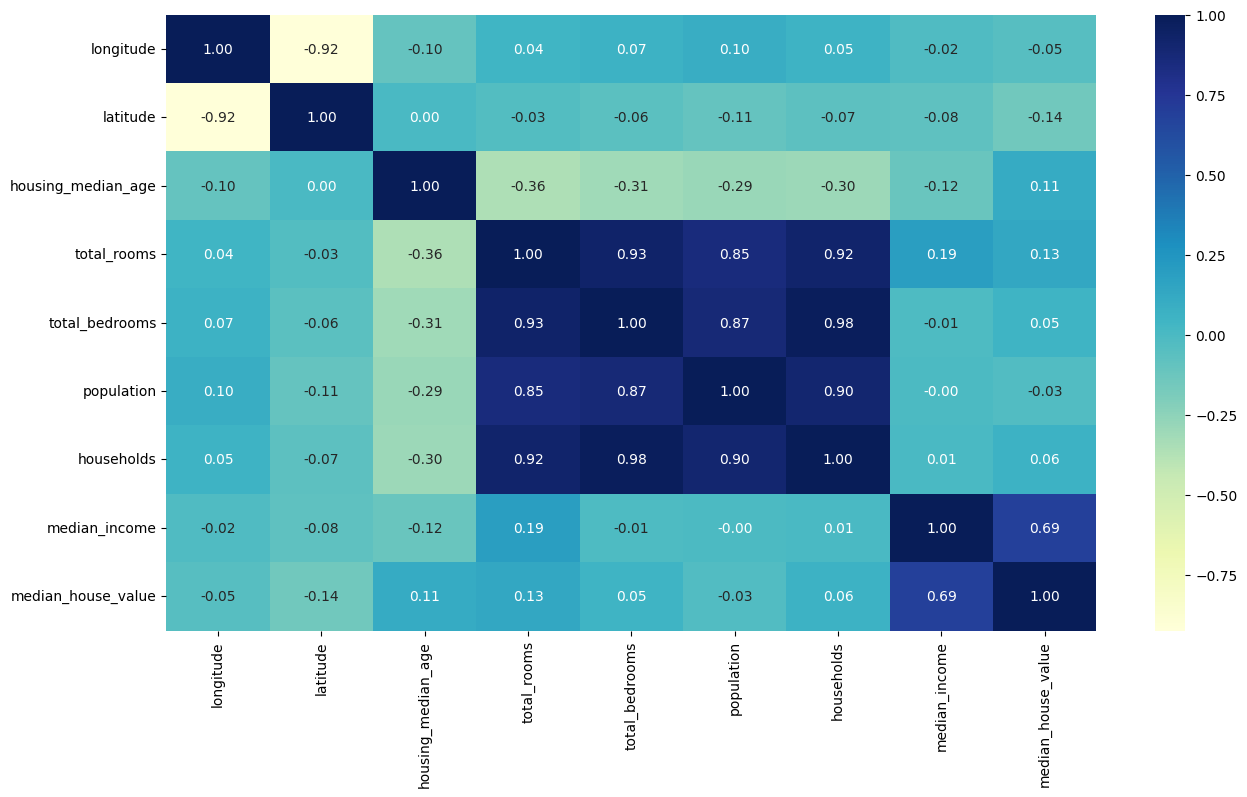

In [172]:
plt.figure(figsize=(15,8))
sb.heatmap(data=df_train[[col for col in df_train.columns if col != 'ocean_proximity']].corr(),annot=True,fmt='.2f',cmap='YlGnBu')

In [173]:
# sb.pairplot(df_train)

In [7]:
cols_drop = ['longitude','latitude','population','households','total_rooms','total_bedrooms']#,'op_ISLAND']

def modify_data(data:pd.DataFrame=None,drop_cols:list[str]=None) -> pd.DataFrame:
    df = data.copy()
    df['lati/long'] = df['latitude'] / df['longitude']
    df['total_rooms/house'] = df['total_rooms'] / df['households']
    df['popl/house'] = df['population'] / df['households']
    df['bedroom - room'] = df['total_rooms'] - df['total_bedrooms']
    df.drop(columns=drop_cols,inplace=True)
    return df

x_train_0 = modify_data(data=x_train,drop_cols=cols_drop)
x_test_0 = modify_data(data=x_test,drop_cols=cols_drop)

array([[<Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'lati/long'}>,
        <Axes: title={'center': 'total_rooms/house'}>],
       [<Axes: title={'center': 'popl/house'}>,
        <Axes: title={'center': 'bedroom - room'}>]], dtype=object)

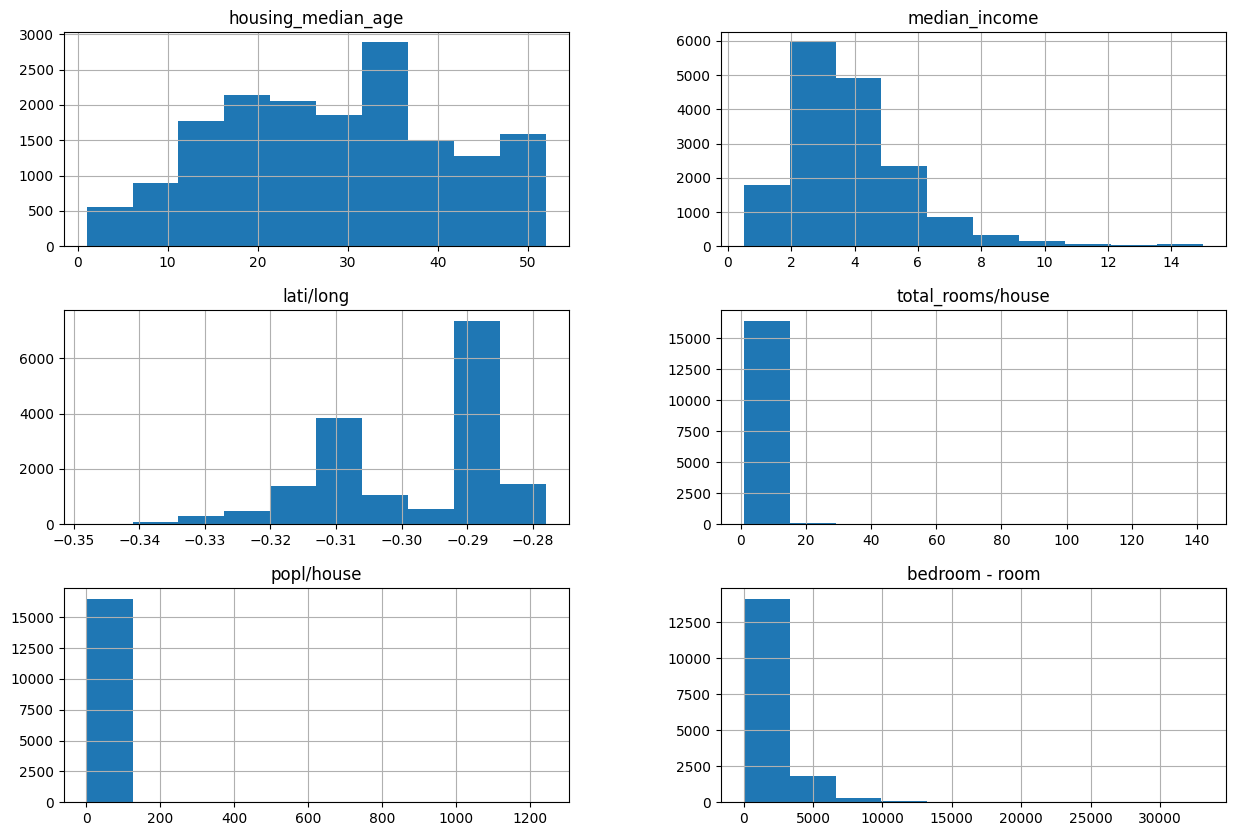

In [175]:
x_train_0.hist(figsize=(15,10))

<Axes: >

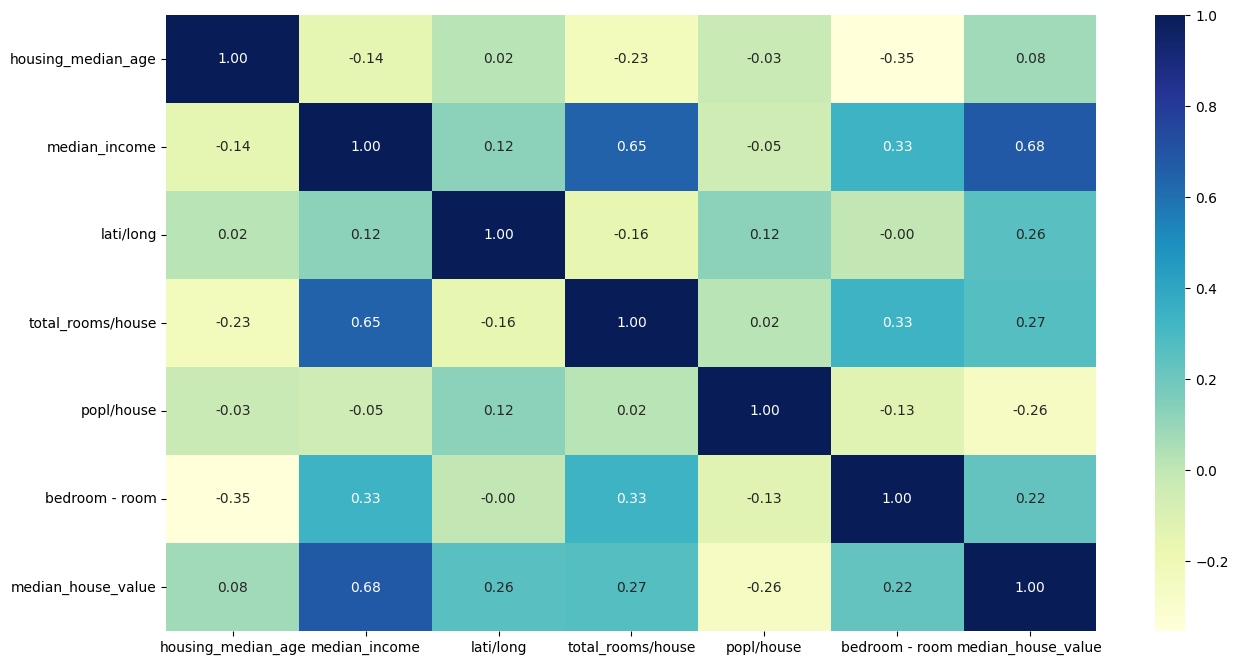

In [176]:
plt.figure(figsize=(15,8))
sb.heatmap(data=x_train_0[[col for col in x_train_0.columns if x_train_0[col].dtypes != 'O']].join(y_train).corr(method='spearman'),annot=True,fmt='.2f',cmap='YlGnBu')


In [177]:
x_train_0.columns

Index(['housing_median_age', 'median_income', 'ocean_proximity', 'lati/long',
       'total_rooms/house', 'popl/house', 'bedroom - room'],
      dtype='object')

In [178]:
# sb.pairplot(x_train_0)

In [8]:
from typing import Literal
def CappingOutlier(data,columns:list[str]=None,threshold:float=3,method:Literal['z-score','iqr']='z-score'):
    df = data.copy()
    for col in columns:
        if method=='z-score':
            mean = df[col].mean()
            std = df[col].std()
            upper_bound = mean + threshold * std
            lower_bound = mean - threshold * std
        elif method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + threshold * IQR
            lower_bound = Q1 - threshold * IQR
        
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound) 
    return df

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, RobustScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder

cols_numr = [col for col in x_train_0.columns if x_train_0[col].dtypes != 'O']
cols_catg = [col for col in x_train_0.columns if x_train_0[col].dtypes == 'O']

# Using OneHotEncoding
ppln_prpc_1 = ColumnTransformer(transformers=[
    ('Numerical_Feats',Pipeline(steps=[
        ('Imputer',KNNImputer(n_neighbors=3)),
        ('Outlier',FunctionTransformer(func=CappingOutlier,kw_args={'columns':cols_numr,'threshold':3,'method':'z-score'})),
        ('Transformer',PowerTransformer(method='yeo-johnson',standardize=False)),
        ('Scaler',RobustScaler(unit_variance=True)),
    ]),cols_numr),
    
    ('Categorical_Feats',Pipeline(steps=[
        ('Encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore',max_categories=4)),
        ('Imputer',KNNImputer(n_neighbors=3)),
    ]),cols_catg),
],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')

# Using OrdinalEncoding
encd_order = [['Less than 1H from OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND', 'INLAND']]
ppln_prpc_2 = ColumnTransformer(transformers=[
    ('Numerical_Feats',Pipeline(steps=[
        ('Imputer',KNNImputer(n_neighbors=3)),
        ('Outlier',FunctionTransformer(func=CappingOutlier,kw_args={'columns':cols_numr,'threshold':3,'method':'z-score'})),
        ('Transformer',PowerTransformer(method='yeo-johnson',standardize=False)),
        ('Scaler',RobustScaler(unit_variance=True)),
    ]),cols_numr),
    
    ('Categorical_Feats',Pipeline(steps=[
        ('Encoder',OrdinalEncoder(categories=encd_order)),#,handle_unknown='use_encoded_value',encoded_missing_value=-1)),
        ('Imputer',KNNImputer(n_neighbors=3)),
    ]),cols_catg),
],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')


ppln_prpc_2

ColumnTransformer(remainder='passthrough',
                  transformers=[('Numerical_Feats',
                                 Pipeline(steps=[('Imputer',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('Outlier',
                                                  FunctionTransformer(func=<function CappingOutlier at 0x73a50db34ea0>,
                                                                      kw_args={'columns': ['housing_median_age',
                                                                                           'median_income',
                                                                                           'lati/long',
                                                                                           'total_rooms/house',
                                                                                           'popl/house',
                                                                                           'bedroom '
                                                                                           '- '
                                                                                           'room'],
                                                                               'method': 'z-score',
                                                                               'th...
                                                  RobustScaler(unit_variance=True))]),
                                 ['housing_median_age', 'median_income',
                                  'lati/long', 'total_rooms/house',
                                  'popl/house', 'bedroom - room']),
                                ('Categorical_Feats',
                                 Pipeline(steps=[('Encoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '1H '
                                                                              'from '
                                                                              'OCEAN',
                                                                              'NEAR '
                                                                              'BAY',
                                                                              'NEAR '
                                                                              'OCEAN',
                                                                              'ISLAND',
                                                                              'INLAND']])),
                                                 ('Imputer',
                                                  KNNImputer(n_neighbors=3))]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

In [10]:
# df_train_1 = ppln_prpc_1.fit_transform(x_train_0)
# df_test_1 = ppln_prpc_1.fit_transform(x_test_0)
# df_train_1

df_train_2 = ppln_prpc_2.fit_transform(x_train_0)
df_test_2 = ppln_prpc_2.fit_transform(x_test_0)
df_train_2

,housing_median_age,median_income,lati/long,total_rooms/house,popl/house,bedroom - room,ocean_proximity
6544,0.344671,-0.693559,0.114546,-2.126034,1.491944,-0.673588,0.0
10095,0.276541,0.321414,0.181811,-0.338555,1.129743,-0.295591,0.0
19362,-1.529553,-0.141655,-1.326187,4.031569,-2.122151,1.894158,2.0
19937,-1.114631,0.094014,-0.901377,1.052670,0.842252,-0.074554,4.0
14473,-0.726062,1.892215,0.878408,1.506309,0.492950,0.599979,2.0
...,...,...,...,...,...,...,...
1571,0.069768,1.411545,-1.187021,1.413227,-0.654080,1.317822,1.0
859,-0.576107,0.598004,-1.095515,0.224912,-0.105020,1.434049,0.0
13193,0.344671,0.194793,0.036462,0.129943,0.660877,1.285381,4.0
10247,-0.502124,1.456758,0.193771,1.540311,0.602017,1.570629,0.0


In [182]:
# import pandas as pd
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.preprocessing import StandardScaler, OrdinalEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

# def detect_outliers_lof(df, n_neighbors=50, contamination='auto'):
#     """
#     Detects outliers in a DataFrame using the Local Outlier Factor (LOF) algorithm
#     and adds a column indicating outlier status.

#     Args:
#         df (pd.DataFrame): The input DataFrame.
#         n_neighbors (int): The number of neighbors to consider (default=20).
#         contamination (float or 'auto'): The estimated proportion of outliers in the data set.
#                                          When set to 'auto', the contamination is set as
#                                          the reciprocal of the number of samples in the data. (default='auto')

#     Returns:
#         pd.DataFrame: The DataFrame with an additional column 'is_outlier' where -1 indicates outliers and 1 indicates inliers.
#     """

    
#     # Scale the data using StandardScaler
#     scaler = StandardScaler().set_output(transform='pandas')
#     df_scaled = scaler.fit_transform(df)
    
#     # Apply LOF
#     lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
#     outlier_scores = lof.fit_predict(df_scaled)

#     # Add the outlier labels to the DataFrame
#     df['is_outlier'] = outlier_scores

#     return df


# df_train_2 = detect_outliers_lof(df_train_2)
# df_train_2

array([[<Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'lati/long'}>],
       [<Axes: title={'center': 'total_rooms/house'}>,
        <Axes: title={'center': 'popl/house'}>,
        <Axes: title={'center': 'bedroom - room'}>],
       [<Axes: title={'center': 'ocean_proximity'}>, <Axes: >, <Axes: >]],
      dtype=object)

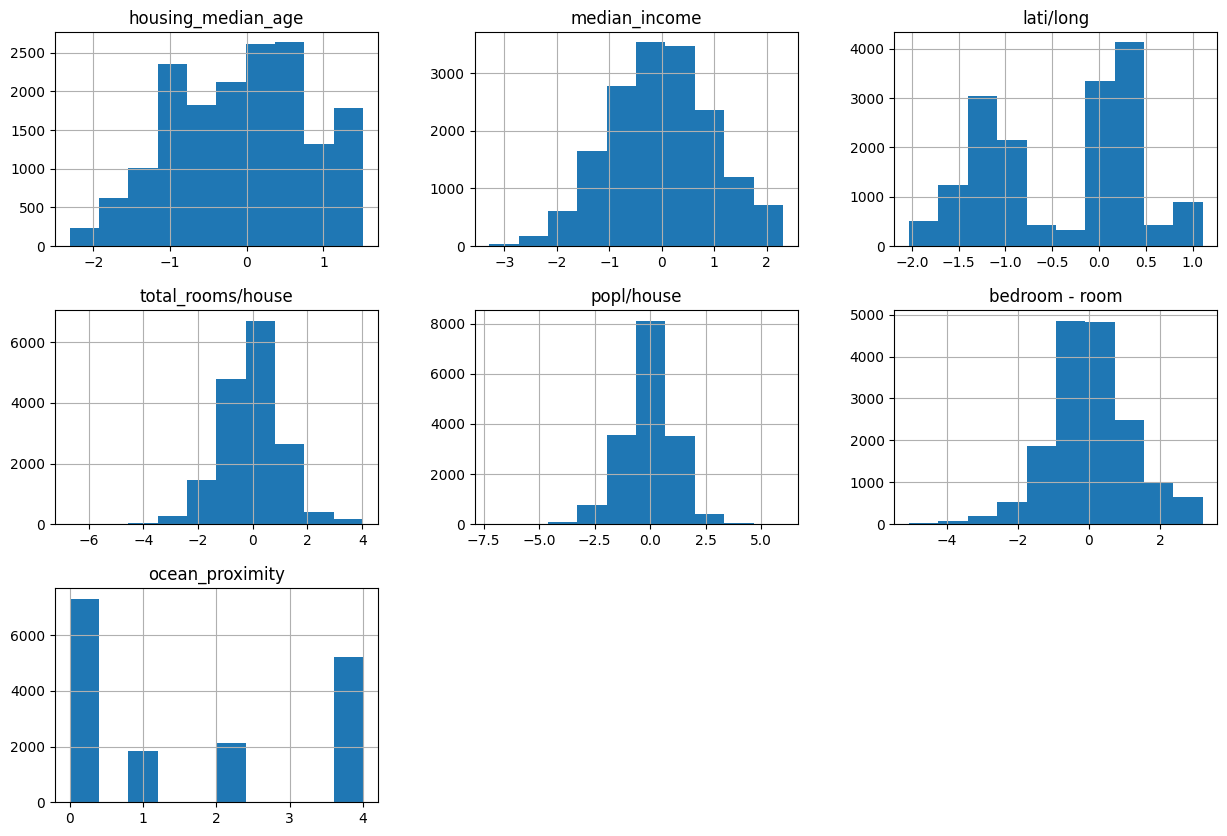

In [183]:
df_train_2.hist(figsize=(15,10))

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA


ppln_fteg_1 = Pipeline(steps=[
    ('ppln_prpc_1',ppln_prpc_1),
    ('Feature_Engineering',PolynomialFeatures(degree=2,include_bias=False)),
    ('Feature_Selection',SelectKBest(score_func=f_regression,k=50)),
    ('Feature_Decomposition',PCA(n_components=30,random_state=42)),
    # ('Scaling', PowerTransformer(method='yeo-johnson',standardize='True')),
]).set_output(transform='pandas')
ppln_fteg_1

ppln_fteg_2 = Pipeline(steps=[
    ('ppln_prpc_2',ppln_prpc_2),
    ('Feature_Engineering',PolynomialFeatures(degree=2,include_bias=False)),
    ('Feature_Selection',SelectKBest(score_func=f_regression,k=50)),
    ('Feature_Decomposition',PCA(n_components=30,random_state=42)),
    # ('Scaling', PowerTransformer(method='yeo-johnson',standardize='True')),
]).set_output(transform='pandas')
ppln_fteg_2

Pipeline(steps=[('ppln_prpc_2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical_Feats',
                                                  Pipeline(steps=[('Imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('Outlier',
                                                                   FunctionTransformer(func=<function CappingOutlier at 0x73a50db34ea0>,
                                                                                       kw_args={'columns': ['housing_median_age',
                                                                                                            'median_income',
                                                                                                            'lati/long',
                                                                                                            'total_rooms/house',
                                                                                                            'popl/house',
                                                                                                            'bedroom '
                                                                                                            '-...
                                                                                               'BAY',
                                                                                               'NEAR '
                                                                                               'OCEAN',
                                                                                               'ISLAND',
                                                                                               'INLAND']])),
                                                                  ('Imputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  ['ocean_proximity'])],
                                   verbose_feature_names_out=False)),
                ('Feature_Engineering', PolynomialFeatures(include_bias=False)),
                ('Feature_Selection',
                 SelectKBest(k=50,
                             score_func=<function f_regression at 0x73a50ce3b2e0>)),
                ('Feature_Decomposition',
                 PCA(n_components=30, random_state=42))])

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from typing import Literal

class MultiModelEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, models, param_grids, cv=3, scoring=None,Method:Literal['GridSearchCV','RandomizedSearchCV','Optuna']='GridSearchCV'):
        self.models = models
        self.param_grids = param_grids
        self.cv = cv
        self.scoring = scoring
        self.method = Method
        self.grid_searches = {}

        if not set(models.keys()).issubset(set(param_grids.keys())):
            missing_params = list(set(models.keys()) - set(param_grids.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)


    def fit(self, X, y=None):
        """
        Fit each model using Method parameter to find the best hyperparameters.
        """
        for name, model in self.models.items():
            print(f"Running GridSearchCV for {name}.")
            if self.method == 'GridSearchCV':
                gs = GridSearchCV(model, self.param_grids[name], cv=self.cv, scoring=self.scoring, refit=True)
                gs.fit(X, y)
            elif self.method == 'RandomizedSearchCV':
                gs = RandomizedSearchCV(model, self.param_grids[name], cv=self.cv, scoring=self.scoring, refit=True,n_jobs=-1)
                gs.fit(X, y)
            elif self.method == 'Optuna':
                pass
            self.grid_searches[name] = gs
            print(f"Best parameters for {name}: {gs.best_params_}")

        return self

    def predict(self, X):
        """
        Transform the data using the best estimator found by GridSearchCV for each model.
        """
        self.predictions_ = {}
        for name, grid_search in self.grid_searches.items():
            best_model = grid_search.best_estimator_
            if hasattr(best_model, 'predict_proba'):
                self.predictions_[name] = best_model.predict_proba(X)
            else:
                self.predictions_[name] = best_model.predict(X)  # or .transform(X) if it's a transformer
        return pd.DataFrame(self.predictions_) #Returns dataframe of predictions

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)

    def get_feature_names_out(self, input_features=None):
         return list(self.predictions_.keys()) #Return column names


In [17]:
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = SVC(probability=True)  # SVC needs probability=True for predict_proba

# Define parameter grids for each model
param_grid1 = {'C': [0.1, 1.0], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
param_grid2 = {'n_estimators': [10, 20], 'max_depth': [5, 10]}
param_grid3 = {'C': [0.1, 1.0], 'kernel': ['rbf', 'linear']}

# Put models and parameter grids into dictionaries
models = {
    'logistic_regression': model1,
    'random_forest': model2,
    'svm': model3
}

param_grids = {
    'logistic_regression': param_grid1,
    'random_forest': param_grid2,
    'svm': param_grid3
}

# Create the multi-model estimator with GridSearchCV
multi_model = MultiModelEstimator(models=models, param_grids=param_grids, cv=3, scoring='accuracy')

# Combine the initial pipeline with the multi-model estimator
full_pipeline = Pipeline([
    ('preprocessing', ppln_fteg_2),
    ('multi_model', multi_model)
])

full_pipeline

AttributeError: 'MultiModelEstimator' object has no attribute 'Method'

AttributeError: 'MultiModelEstimator' object has no attribute 'Method'

AttributeError: 'MultiModelEstimator' object has no attribute 'Method'

In [185]:
df_train_1 = ppln_fteg_1.fit_transform(x_train_0,y_train)
df_test_1 = ppln_fteg_1.fit_transform(x_test_0,y_test)
df_train_1

df_train_2 = ppln_fteg_2.fit_transform(x_train_0,y_train)
df_test_2 = ppln_fteg_2.fit_transform(x_test_0,y_test)
df_train_2

/home/who/Documents/Coding/P-1_Titanic_Binary-Classification/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=50 is greater than n_features=35. All the features will be returned.
  warnings.warn(
/home/who/Documents/Coding/P-1_Titanic_Binary-Classification/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=50 is greater than n_features=35. All the features will be returned.
  warnings.warn(


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29
6544,-6.233143,-0.164306,2.436758,0.839941,0.897725,0.438004,-3.451765,0.669800,-1.808253,1.297519,...,0.722606,-0.503359,-0.054493,-0.200742,-0.148471,0.016912,0.117995,-0.194948,-0.215429,0.056155
10095,-6.119723,-0.233959,-1.871739,0.709466,0.338093,0.437514,-0.132861,-0.042577,-0.636160,0.461424,...,0.401788,-0.055200,-0.337366,-0.342527,0.408564,0.171599,0.078065,-0.285788,-0.220258,0.040843
19362,0.105625,11.343904,13.275618,-5.552731,5.701029,2.758514,-7.192267,3.735926,-8.464503,2.780341,...,-0.583348,2.487702,-0.726637,2.328852,-2.377702,0.879324,-0.397981,-1.121429,0.337430,0.052532
19937,11.471492,2.430103,-0.786834,3.433360,3.252429,1.364175,0.098857,-2.789989,0.358121,-0.887945,...,-0.101682,-0.355858,-0.126263,-0.200516,0.097002,-0.064270,0.538237,0.047796,-0.002464,-0.017584
14473,-2.304237,4.206268,1.030179,1.338259,2.371580,-0.834222,-0.713934,-1.457665,3.919167,0.141719,...,0.126499,0.725383,-0.355256,-0.045940,-0.716653,-0.254060,-1.179305,0.865058,-0.238296,-0.347511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,-4.640419,3.253406,1.035493,-0.457060,1.210933,-1.382868,-0.417409,1.078622,-0.466543,-1.141373,...,-0.196601,0.425448,-0.318013,1.109193,0.054534,0.162403,0.146631,0.310926,-0.127694,-0.371607
859,-5.898984,1.081301,-0.971754,0.379839,-0.467213,-1.247273,1.465949,-0.053954,-0.932739,-0.324481,...,0.219359,0.471059,-0.287178,-0.035563,-0.611367,-0.168741,-0.213455,0.697974,-0.027449,0.248442
13193,9.658629,2.802526,-2.264650,3.077629,-2.422804,-0.504037,-1.130447,2.853528,4.222135,1.484671,...,0.171361,0.612021,0.698005,0.663495,0.149710,0.605930,-0.122515,-0.702155,0.786089,0.624323
10247,-6.106762,1.309422,2.513822,-0.266859,-0.241281,-2.431928,0.295985,-0.939342,1.327033,-1.088572,...,0.116176,-0.140980,-0.378287,-0.227412,0.543963,0.140949,0.398823,-0.087096,-0.102854,-0.040348


<Axes: >

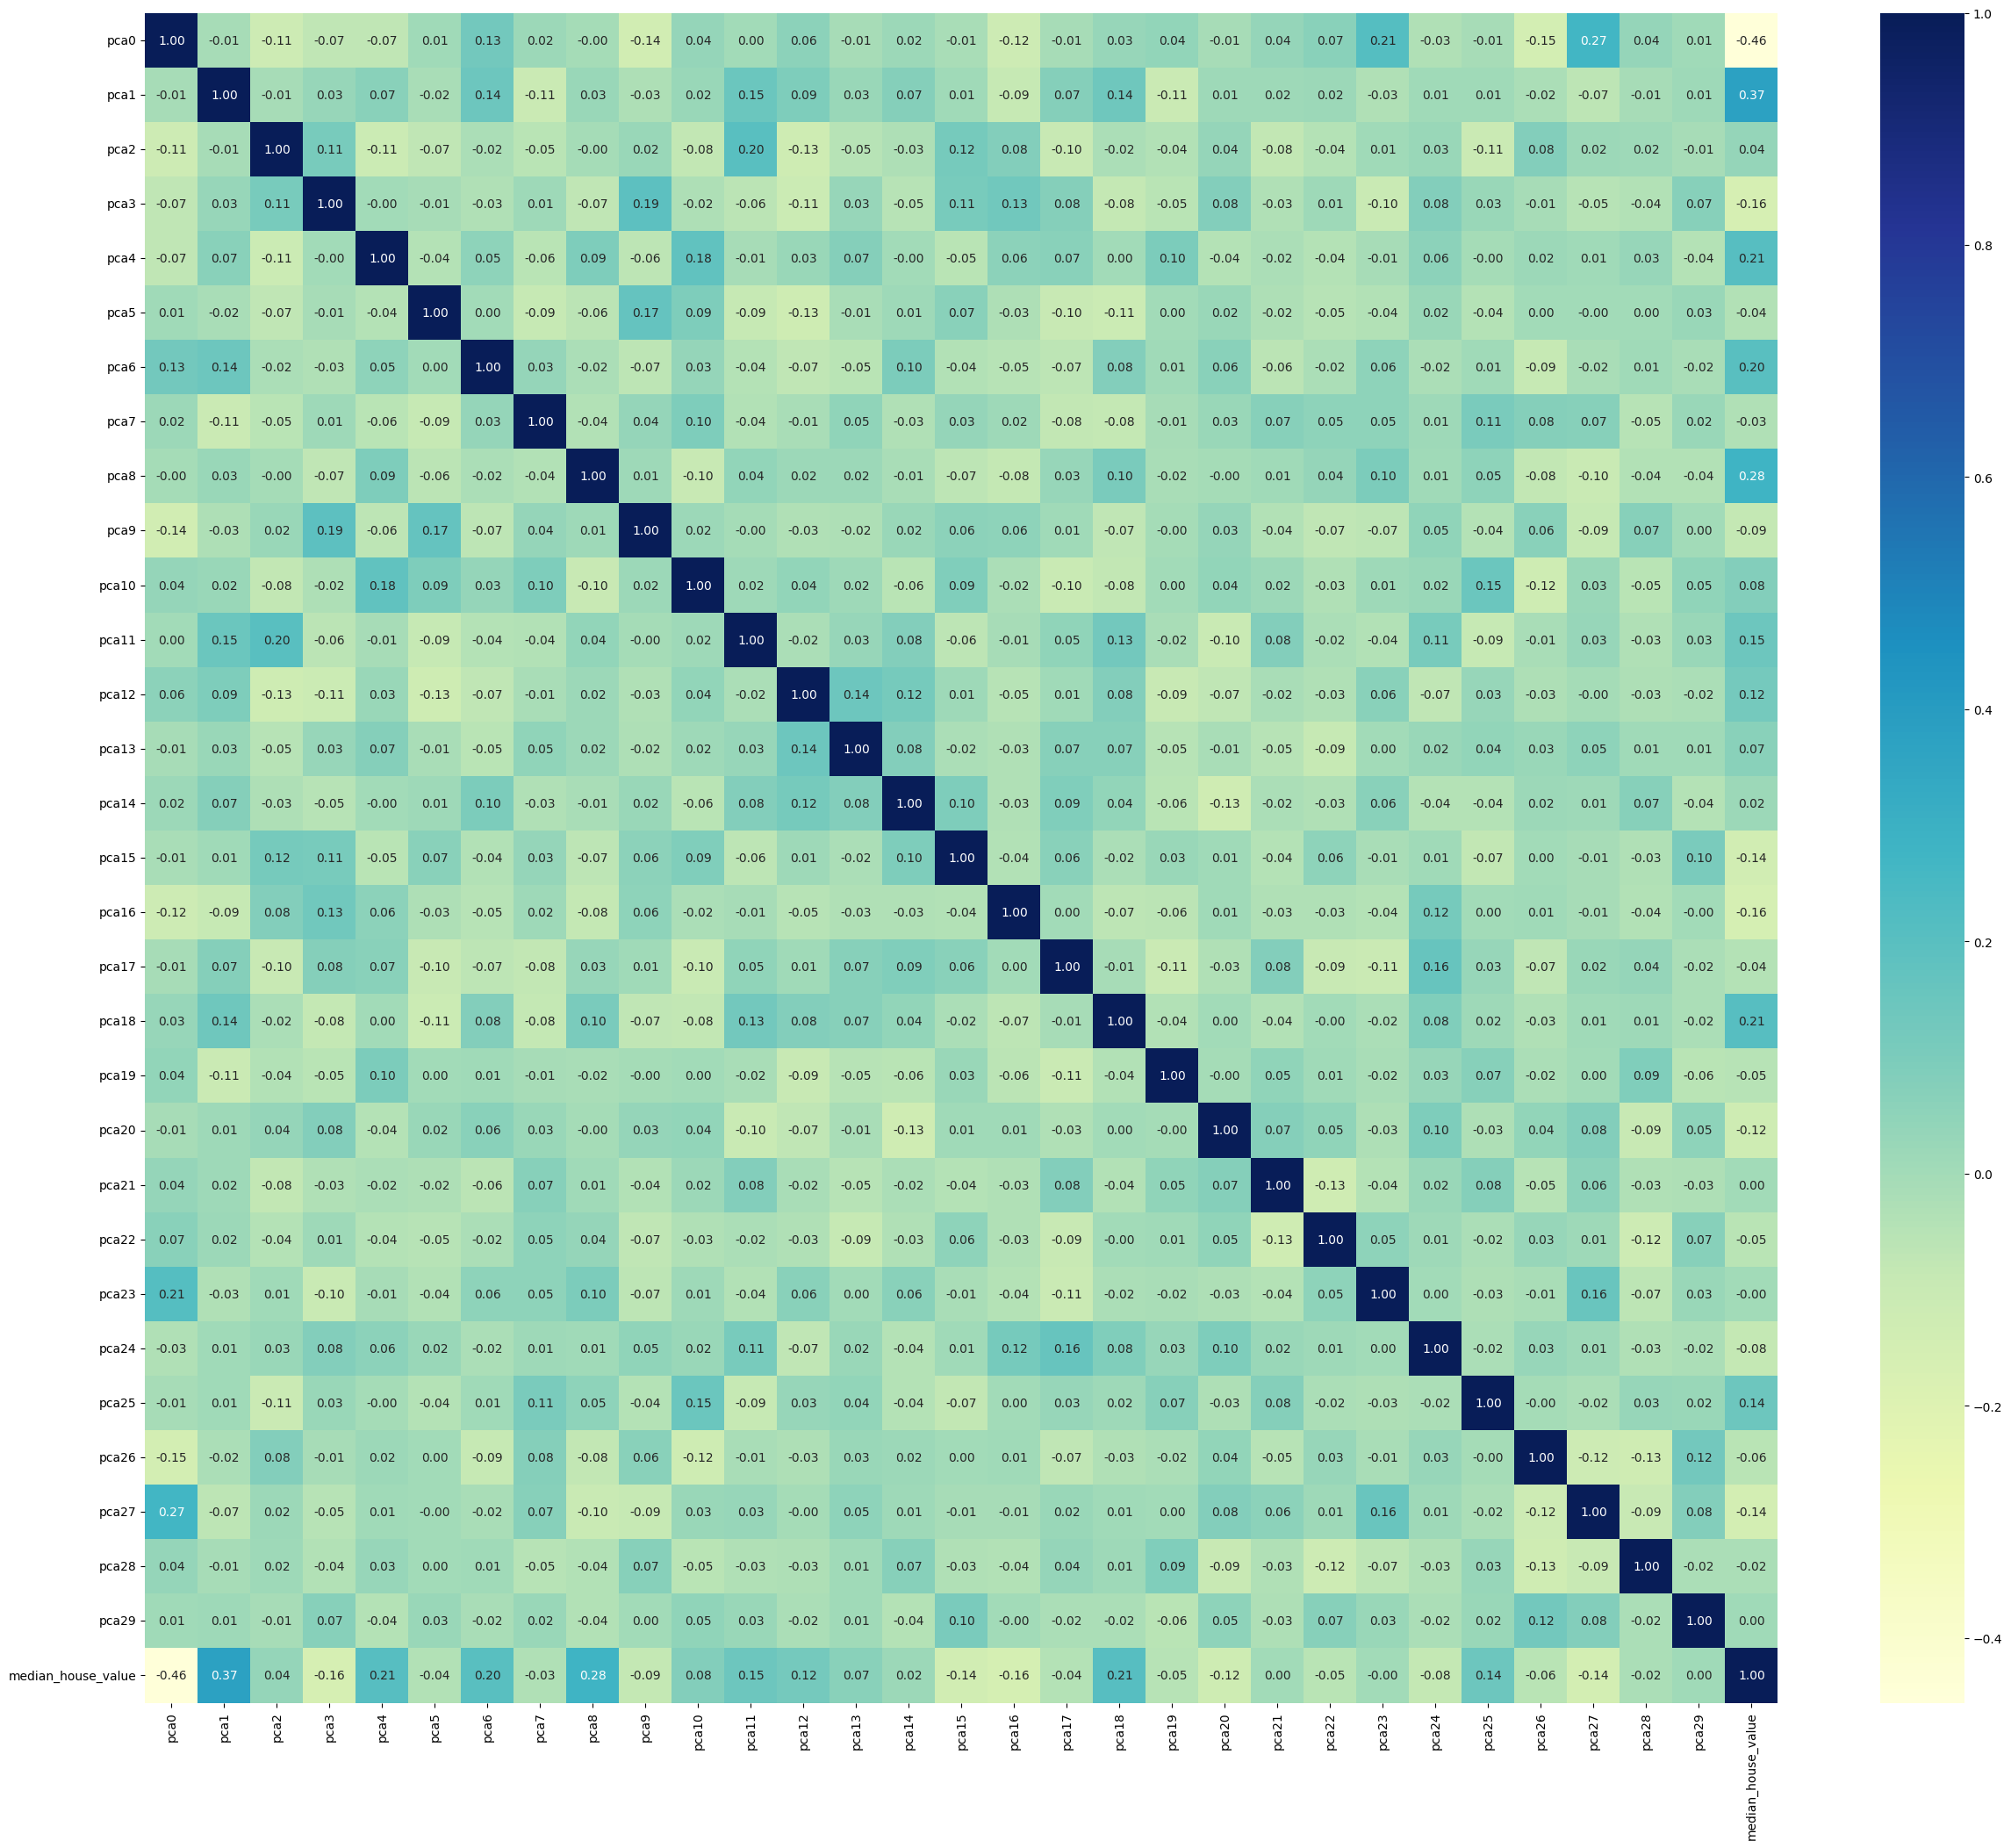

In [186]:
plt.figure(figsize=(30,25))
sb.heatmap(data=df_train_2.join(y_train).corr(method='spearman'),annot=True,fmt='.2f',cmap='YlGnBu')


array([[<Axes: title={'center': 'pca0'}>,
        <Axes: title={'center': 'pca1'}>,
        <Axes: title={'center': 'pca2'}>,
        <Axes: title={'center': 'pca3'}>,
        <Axes: title={'center': 'pca4'}>],
       [<Axes: title={'center': 'pca5'}>,
        <Axes: title={'center': 'pca6'}>,
        <Axes: title={'center': 'pca7'}>,
        <Axes: title={'center': 'pca8'}>,
        <Axes: title={'center': 'pca9'}>],
       [<Axes: title={'center': 'pca10'}>,
        <Axes: title={'center': 'pca11'}>,
        <Axes: title={'center': 'pca12'}>,
        <Axes: title={'center': 'pca13'}>,
        <Axes: title={'center': 'pca14'}>],
       [<Axes: title={'center': 'pca15'}>,
        <Axes: title={'center': 'pca16'}>,
        <Axes: title={'center': 'pca17'}>,
        <Axes: title={'center': 'pca18'}>,
        <Axes: title={'center': 'pca19'}>],
       [<Axes: title={'center': 'pca20'}>,
        <Axes: title={'center': 'pca21'}>,
        <Axes: title={'center': 'pca22'}>,
        <Axes: ti

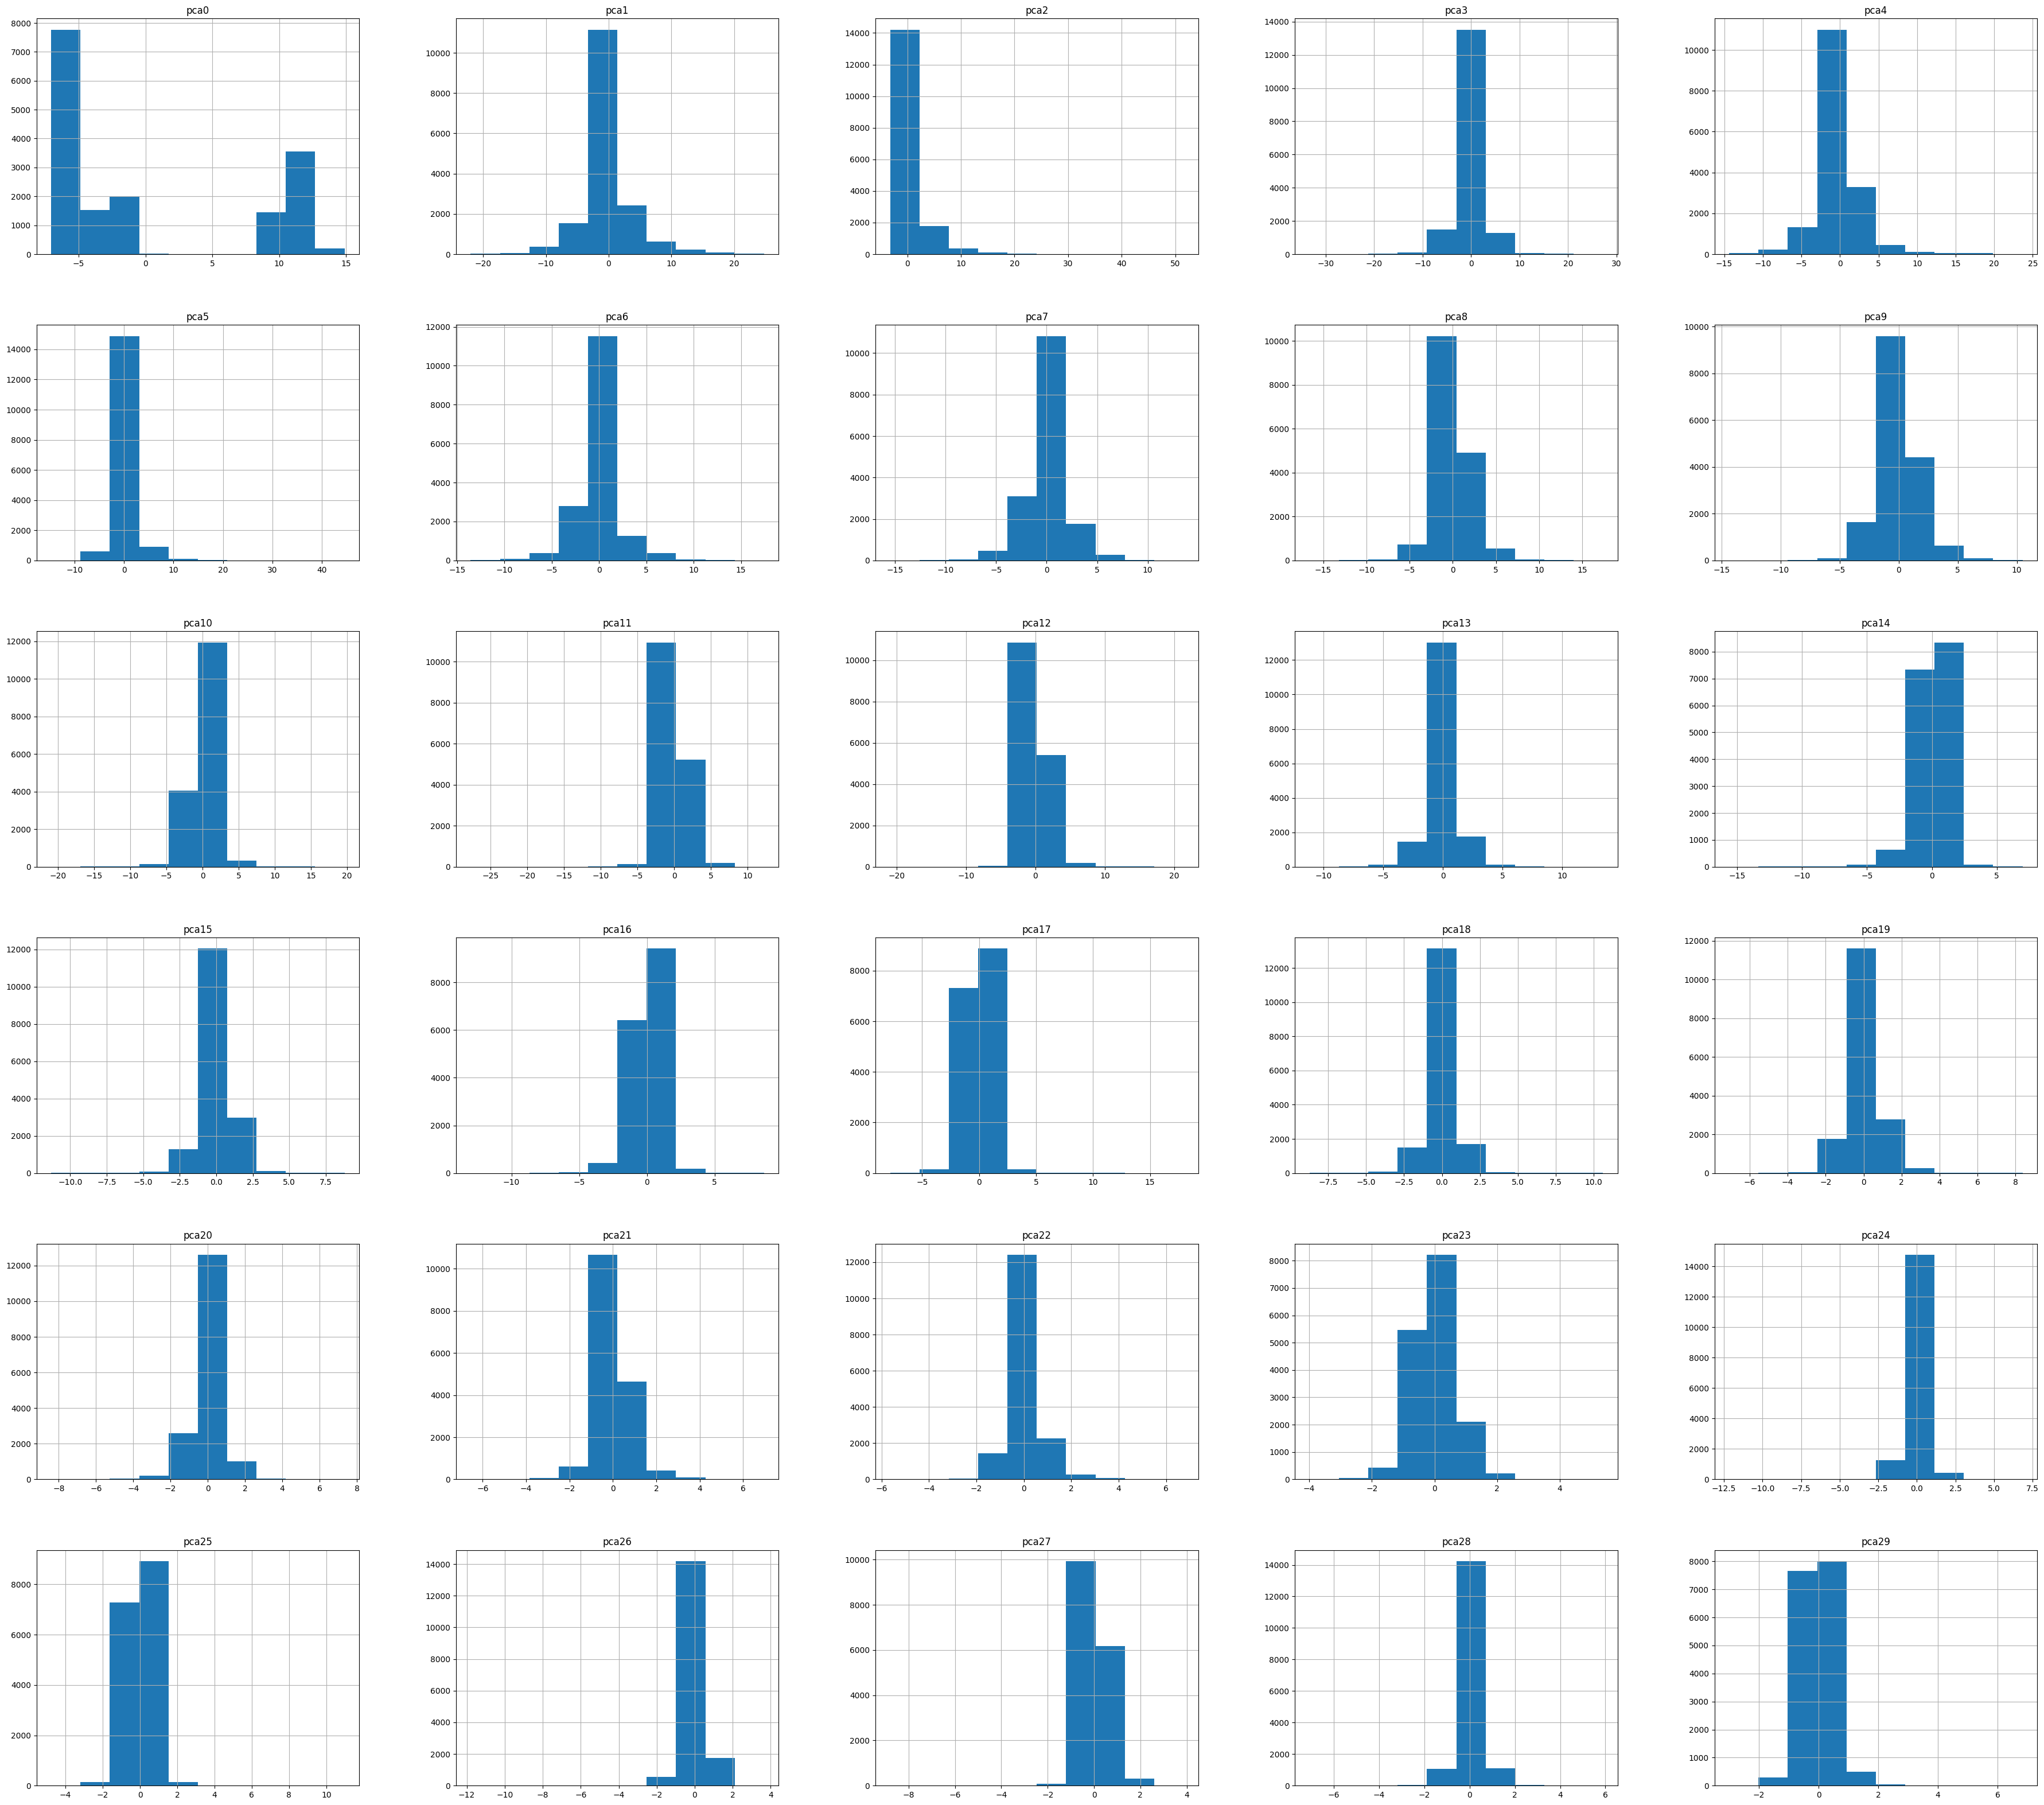

In [187]:
df_train_2.hist(figsize=(45,40))

In [188]:
# for col in cols_numr_1:
# # for col in df_train.columns:
#     qqplot(data=df_train_1[col],line='45')
#     plt.title(f'QQplot of "{col}"')

In [189]:
from sklearn.linear_model import (LinearRegression, Lasso, Ridge, ElasticNet)
from sklearn.ensemble import (RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor,BaggingRegressor,AdaBoostRegressor,VotingRegressor,StackingRegressor,HistGradientBoostingRegressor)
from sklearn.tree import (DecisionTreeRegressor, ExtraTreeRegressor)
from lightgbm import (LGBMRegressor,DaskLGBMRegressor)
from xgboost import (XGBRegressor,XGBRFRegressor)

In [190]:
model_dict = {
    'LinearRegression':LinearRegression(n_jobs=-1),
    'Lasso':Lasso(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    
    'RandomForestRegressor':RandomForestRegressor(n_jobs=-1,random_state=12),
    # 'ExtraTreesRegressor':ExtraTreesRegressor(n_jobs=-1,random_state=12),
    # # 'VotingRegressor':VotingRegressor(n_jobs=-1),
    # # 'StackingRegressor':StackingRegressor(n_jobs=-1),
    # 'BaggingRegressor':BaggingRegressor(n_jobs=-1,random_state=12),
    # 'GradientBoostingRegressor':GradientBoostingRegressor(random_state=12),
    # 'AdaBoostRegressor':AdaBoostRegressor(random_state=12),
    # 'HistGradientBoostingRegressor':HistGradientBoostingRegressor(random_state=12),
    
    # 'DecisionTreeRegressor':DecisionTreeRegressor(random_state=12),
    # 'ExtraTreeRegressor':ExtraTreeRegressor(random_state=12),
    
    # 'LGBMRegressor':LGBMRegressor(n_jobs=-1,random_state=12),
    # 'DaskLGBMRegressor':DaskLGBMRegressor(n_jobs=-1,random_state=12),
    
    # 'XGBRegressor':XGBRegressor(n_jobs=-1),
    # 'XGBRFRegressor':XGBRFRegressor(n_jobs=-1),
}

param_dict = {
    'LinearRegression':{},
    'Lasso':{'alpha':[0.05,0.1]},
    'Ridge':{'alpha':[0.05,0.1],'solver':['auto','cholesky','lsqr']},
    'ElasticNet':{'alpha':[0.05,0.1],'l1_ratio':[0.2,0.4,0.5,0.6,0.8]},
    
    'RandomForestRegressor':{'n_estimators':[300],'criterion':['friedman_mse'],'max_depth':[60,80]},
    # 'ExtraTreesRegressor':{'n_estimators':[100,200],'criterion':['squared_error','friedman_mse'],'max_depth':[None,10,20]},
    # # 'VotingRegressor':{},
    # # 'StackingRegressor':{},
    # 'BaggingRegressor':{'n_estimators':[100,200]},
    # 'GradientBoostingRegressor':{'n_estimators':[100,200],'criterion':['squared_error','friedman_mse'],'max_depth':[None,10,20],'loss':['squared_error','huber']},
    # 'AdaBoostRegressor':{'n_estimators':[100,200],'learning_rate':[0.05,0.1,0.5,1],'loss':['linear','square']},
    # 'HistGradientBoostingRegressor':{'loss':['squared_error','poisson'],'learning_rate':[0.05,0.1,0.2],'max_depth':[None,10,20]},
    
    # 'DecisionTreeRegressor':{'criterion':['squared_error','friedman_mse','poisson'],'max_depth':[None,10,20]},
    # 'ExtraTreeRegressor':{'criterion':['squared_error','friedman_mse','poisson'],'max_depth':[None,10,20]},
    
    # 'LGBMRegressor':{'learning_rate':[0.05,0.1,0.2],'max_depth':[-1,10,20],'n_estimators':[100,200]},
    # 'DaskLGBMRegressor':{'learning_rate':[0.05,0.1,0.2],'max_depth':[-1,10,20],'n_estimators':[100,200]},
    
    # 'XGBRegressor':{'learning_rate':[0.05,0.1,0.2]},
    # 'XGBRFRegressor':{'learning_rate':[0.05,0.1,0.2]}, 
}

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

def evaluate_models(x_train,y_train,x_test,y_test,Models:dict,Params:dict):
    Model_Scores={}
    
    for i in range(len(list(Models))):
        model_name = list(Models.keys())[i]
        
        model = list(Models.values())[i]
        param = Params[model_name]
        
        gs = GridSearchCV(model,param,cv=3)
        gs.fit(x_train,y_train)
        
        model.set_params(**gs.best_params_)
        model.fit(x_train,y_train)
        print(gs.best_params_)
        
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        
        model_train_score = r2_score(y_train,y_train_pred)
        model_test_score = r2_score(y_test,y_test_pred)
        
        Model_Scores[model_name] = [model_train_score,model_test_score]
        print(f'{model_name}: {[model_train_score*100,model_test_score*100]}')

    Model_Scores = dict(
        sorted(Model_Scores.items(), key=lambda item: item[1][1], reverse=True)
    )

    Max_model = dict(
        sorted(Model_Scores.items(), key=lambda item: item[1][1], reverse=True)[:1]
    )
    
    return (Model_Scores,Max_model)

In [192]:
# Model_Scores,Max_model = evaluate_models(df_train_2,y_train,df_test_2,y_test,Models=model_dict,Params=param_dict)

# Model_Scores

#### ppln_0

* {'criterion': 'friedman_mse', 'max_depth': 80, 'n_estimators': 300}: RandomForestRegressor: [97.13057907008219, 76.58700966153297]

#### ppln_1
* {'criterion': 'friedman_mse', 'max_depth': 80, 'n_estimators': 300}: RandomForestRegressor: [97.12994300755541, 75.58071084041073]

#### ppln_2
* {'criterion': 'friedman_mse', 'max_depth': 80, 'n_estimators': 300}: RandomForestRegressor: [97.13065064259206, 58.440191230683446]

#### ppln_3

* {'criterion': 'friedman_mse', 'max_depth': 80, 'n_estimators': 300}: RandomForestRegressor: [97.12994702486098, 76.5804079793922]

#### ppln_4
* {'criterion': 'friedman_mse', 'max_depth': 80, 'n_estimators': 300}: RandomForestRegressor: [97.13498784791256, 76.57799524160083]

In [193]:
from sklearn.pipeline import make_pipeline, Pipeline

ppln_rf_1 = Pipeline(steps=[
    ('Preprocessing',ppln_fteg_1),
    ('RF_Estimator',RandomForestRegressor(n_estimators=300,max_depth=60,criterion='friedman_mse',n_jobs=-1,random_state=45)),
])
ppln_rf_1

ppln_rf_2 = Pipeline(steps=[
    ('Preprocessing',ppln_fteg_2),
    ('RF_Estimator',RandomForestRegressor(n_estimators=300,max_depth=60,criterion='friedman_mse',n_jobs=-1,random_state=45)),
])
ppln_rf_2

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('ppln_prpc_2',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Numerical_Feats',
                                                                   Pipeline(steps=[('Imputer',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('Outlier',
                                                                                    FunctionTransformer(func=<function CappingOutlier at 0x75b07b767a60>,
                                                                                                        kw_args={'columns': ['housing_median_age',
                                                                                                                             'median_income',
                                                                                                                             'lati/long',
                                                                                                                             'total_room...
                                                    verbose_feature_names_out=False)),
                                 ('Feature_Engineering',
                                  PolynomialFeatures(include_bias=False)),
                                 ('Feature_Selection',
                                  SelectKBest(k=50,
                                              score_func=<function f_regression at 0x75b07fccab60>)),
                                 ('Feature_Decomposition',
                                  PCA(n_components=30, random_state=42))])),
                ('RF_Estimator',
                 RandomForestRegressor(criterion='friedman_mse', max_depth=60,
                                       n_estimators=300, n_jobs=-1,
                                       random_state=45))])

In [194]:
from sklearn.metrics import root_mean_squared_error, r2_score

In [195]:
# ppln_rf_1.fit(x_train_0,y_train)

# y_pred_train_1 = ppln_rf_1.predict(x_train_0)
# y_pred_test_1 = ppln_rf_1.predict(x_test_0)

# rms_train_1 = root_mean_squared_error(y_train,y_pred_train_1)
# rms_test_1 = root_mean_squared_error(y_test,y_pred_test_1)

# r2_train_1 = r2_score(y_train,y_pred_train_1)
# r2_test_1 = r2_score(y_test,y_pred_test_1)

In [196]:
ppln_rf_2.fit(x_train_0,y_train)

y_pred_train_2 = ppln_rf_2.predict(x_train_0)
y_pred_test_2 = ppln_rf_2.predict(x_test_0)

rms_train_2 = root_mean_squared_error(y_train,y_pred_train_2)
rms_test_2 = root_mean_squared_error(y_test,y_pred_test_2)

r2_train_2 = r2_score(y_train,y_pred_train_2)
r2_test_2 = r2_score(y_test,y_pred_test_2)

/home/who/Documents/Coding/P-1_Titanic_Binary-Classification/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=50 is greater than n_features=35. All the features will be returned.
  warnings.warn(


In [197]:
# df = pd.DataFrame(data={
#     'Train-1':[rms_train_1,r2_train_1],
#     'Train-2':[rms_train_2,r2_train_2],
#     'Test-1' :[rms_test_1,r2_test_1],
#     'Test-2' :[rms_test_2,r2_test_2],
#     },index=['RMS','R2'])

# df

In [2]:
import pandas as pd

df_scores = pd.read_pickle(r'../artifacts/DataFrames/df_prpc.pkl')
df_scores

,housing_median_age,median_income,lati/long,total_rooms/house,popl/house,bedroom - room,ocean_proximity
0,0.682202,0.556158,0.260764,-0.043981,-0.917431,0.240681,0.0


In [ ]:
# from autoviz.AutoViz_Class import AutoViz_Class
# import pandas as pd

# av = AutoViz_Class()
# df = pd.read_csv(r'../artifacts/Data/train.csv')
# target_variable = 'median_house_value'
# dft = av.AutoViz(
#     filename=None,
#     sep=",",
#     depVar=target_variable,
#     dfte=df,
#     header=0,
#     verbose=2,
#     lowess=False,
#     chart_format="html",
#     max_rows_analyzed=150000,
#     max_cols_analyzed=30,
#     save_plot_dir='../templates/AutoViz_Plots/'
# )

Shape of your Data Set loaded: (16512, 10)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
    Integer-Categorical Columns: []
    String-Categorical Columns: ['ocean_proximity']
    Factor-Categorical Columns: []
    String-Boolean Columns: []
    Numeric-Boolean Columns: []
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: []
    Columns that will not be considered in modeling: []
    9 Predictors classified...
        No variables removed since no ID or low-information variables found in da

Saving scatterplots in HTML format


Saving pair_scatters in HTML format


Saving distplots_cats in HTML format


Saving distplots_nums in HTML format


Saving kde_plots in HTML format


Saving violinplots in HTML format


Saving heatmaps in HTML format


Saving cat_var_plots in HTML format
                                             

Time to run AutoViz (in seconds) = 118
